smote 사용 안한 1차 데이터 처리
train 먼저 진행후, 높은 정확도 보이는 test 데이터 한해서 학습 진행 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [45]:
csv_data = r"healthcare-dataset-stroke-data.csv"
df = pd.read_csv(csv_data)
df.head(5)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [46]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
df['avg_glucose_level'] = df['avg_glucose_level'].fillna(df['avg_glucose_level'].mean())
df['age'] = df['age'].fillna(df['age'].mean()).round()

df['hypertension'] = df['hypertension'].apply(lambda x: 1 if x == 1 else 0)
df['heart_disease'] = df['heart_disease'].apply(lambda x: 1 if x == 1 else 0)
df['smoking_status'] = df['smoking_status'].replace({
    'never smoked': 0, 
    'smokes': 1, 
    'formerly smoked': 0.5, 
    'Unknown': 0.5
})
df['Residence_type'] = df['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)

df = df.drop_duplicates()

df.head(10)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,1,228.69,36.600000,0.5,1
1,51676,Female,61.0,0,0,Yes,Self-employed,0,202.21,28.893237,0.0,1
2,31112,Male,80.0,0,1,Yes,Private,0,105.92,32.500000,0.0,1
3,60182,Female,49.0,0,0,Yes,Private,1,171.23,34.400000,1.0,1
4,1665,Female,79.0,1,0,Yes,Self-employed,0,174.12,24.000000,0.0,1
5,56669,Male,81.0,0,0,Yes,Private,1,186.21,29.000000,0.5,1
6,53882,Male,74.0,1,1,Yes,Private,0,70.09,27.400000,0.0,1
7,10434,Female,69.0,0,0,No,Private,1,94.39,22.800000,0.0,1
8,27419,Female,59.0,0,0,Yes,Private,0,76.15,28.893237,0.5,1
9,60491,Female,78.0,0,0,Yes,Private,1,58.57,24.200000,0.5,1


In [47]:
# 범주형 및 수치형 컬럼 분리
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

In [48]:
# One-Hot Encoding 및 데이터 스케일링
ohe = OneHotEncoder(drop='first', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_columns),  # 범주형 컬럼
        ('num', StandardScaler(), numerical_columns)  # 수치형 컬럼
    ],
    remainder='passthrough'  # 나머지 컬럼은 그대로 유지
)


In [49]:
# 입력 데이터(X) 및 타겟 데이터(y) 설정
y = df['stroke']
X = df[categorical_columns + numerical_columns]
X_transformed = preprocessor.fit_transform(X)

#y = df['stroke']
#X = df[categorical_columns + numerical_columns]
#X_transformed = preprocessor.fit_transform(X)
#df.columns

In [50]:
scaler = StandardScaler()
# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.3, random_state=42, stratify=y)

In [51]:
from sklearn.decomposition import PCA # type: ignore

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

In [52]:
# Perceptron
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron.fit(X_train_2d, y_train)
train_accuracy_perceptron = accuracy_score(y_train, perceptron.predict(X_train_2d))

print("train_accuracy_perceptron", train_accuracy_perceptron)

train_accuracy_perceptron 0.8568632932625104


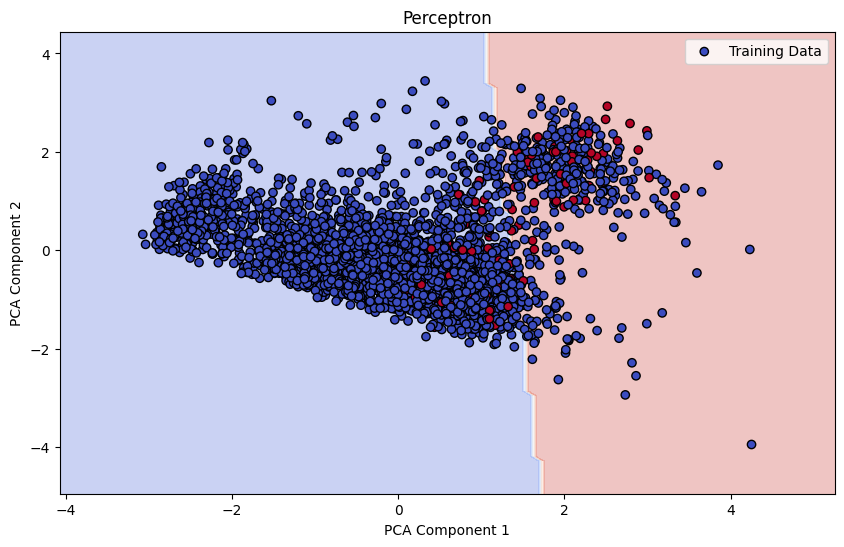

In [53]:
# 결정 경계 시각화
xx, yy = np.meshgrid(
    np.linspace(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 100),
    np.linspace(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 100)
)
Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', label="Training Data")
plt.title("Perceptron")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [54]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
        #return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [55]:
# AdalineGD
adaline_gd = AdalineGD(eta=0.1, n_iter=100)
adaline_gd.fit(X_train_2d, y_train)
train_accuracy_adaline_gd = accuracy_score(y_train, adaline_gd.predict(X_train_2d))
print(f"AdalineGD Training Accuracy: {train_accuracy_adaline_gd:.4f}")

AdalineGD Training Accuracy: 0.0011


c:\Users\LYJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


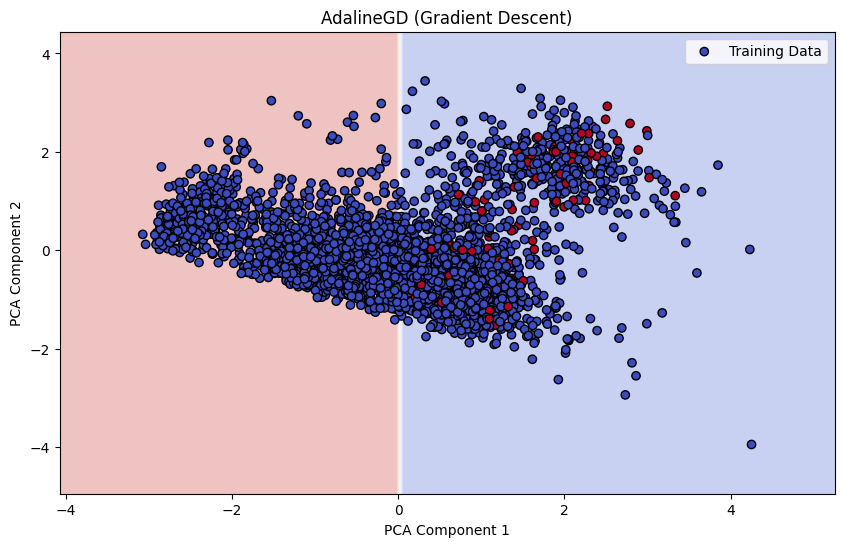

In [56]:
# AdalineGD 결정 경계 시각화
xx, yy = np.meshgrid(
    np.linspace(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 100),
    np.linspace(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 100)
)
Z = adaline_gd.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', label="Training Data")
plt.title("AdalineGD (Gradient Descent)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [57]:
# AdalineSGD
from sklearn.linear_model import SGDClassifier

adaline_sgd = SGDClassifier(loss='squared_error', max_iter=1000, tol=1e-3, random_state=42)
adaline_sgd.fit(X_train_2d, y_train)
train_accuracy_adaline_sgd = accuracy_score(y_train, adaline_sgd.predict(X_train_2d))
print(f"AdalineSGD Training Accuracy: {train_accuracy_adaline_sgd:.4f}")

AdalineSGD Training Accuracy: 0.9511


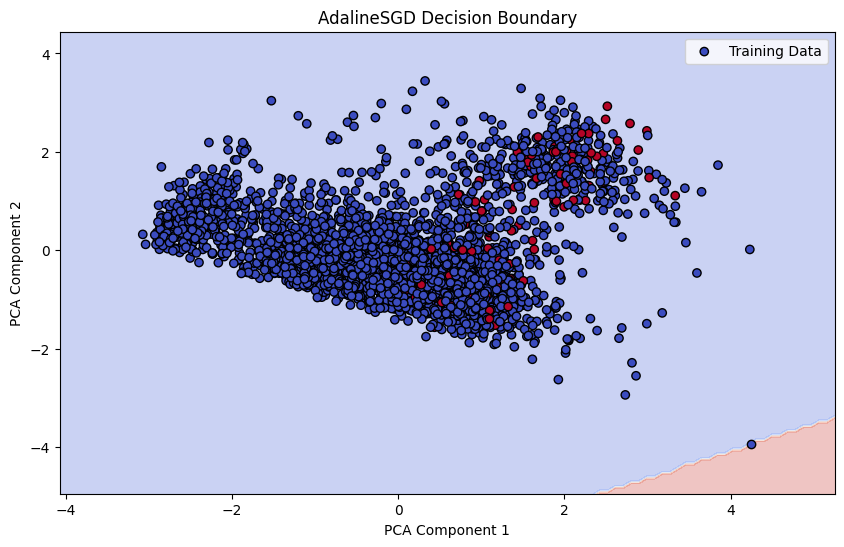

In [58]:
# AdalineSGD 결정 경계 시각화
Z = adaline_sgd.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', label="Training Data")
plt.title("AdalineSGD Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [59]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression 모델 학습
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# 모델 학습 (PCA 적용된 오버샘플링된 훈련 데이터 사용)
log_reg.fit(X_train_2d, y_train)  # y_train_oversampled 사용

# 훈련 데이터 정확도 계산
y_train_pred = log_reg.predict(X_train_2d)
train_accuracy = accuracy_score(y_train, y_train_pred)  # y_train_oversampled 사용
print(f"Logistic Regression Training Accuracy: {train_accuracy:.4f}")

Logistic Regression Training Accuracy: 0.9514


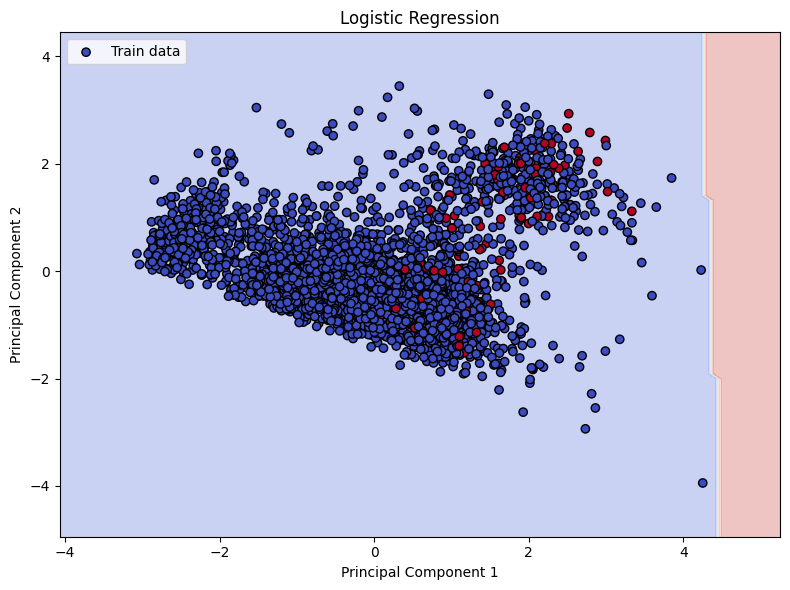

In [61]:
plt.figure(figsize=(8, 6))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', label='Train data')

plt.title('Logistic Regression')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_2d, y_train)
train_accuracy_knn = accuracy_score(y_train, knn.predict(X_train_2d))

print("train_accuracy_knn", train_accuracy_knn)

train_accuracy_knn 0.9510763209393346


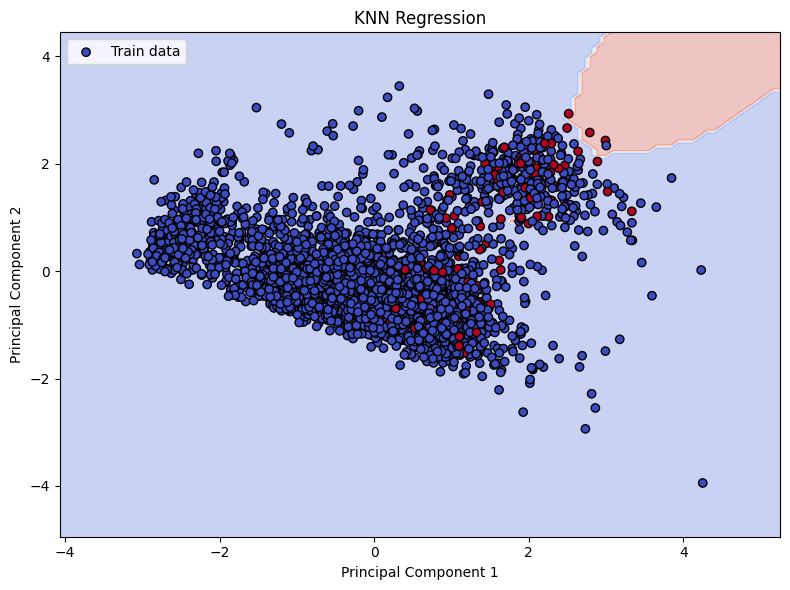

In [ ]:
plt.figure(figsize=(8, 6))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', label='Train data')

plt.title('KNN Regression')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [68]:
# DecisionTree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,             # 최대 트리 깊이를 제한하여 과적합 방지
    min_samples_split=10,    # 분할에 필요한 최소 샘플 수를 설정
    min_samples_leaf=5       # 리프 노드에 있어야 하는 최소 샘플 수를 설정
)
dt.fit(X_train_2d, y_train)
train_accuracy_dt = accuracy_score(y_train, dt.predict(X_train_2d))

print("train_accuracy_dt",train_accuracy_dt)

train_accuracy_dt 0.9513558848196813


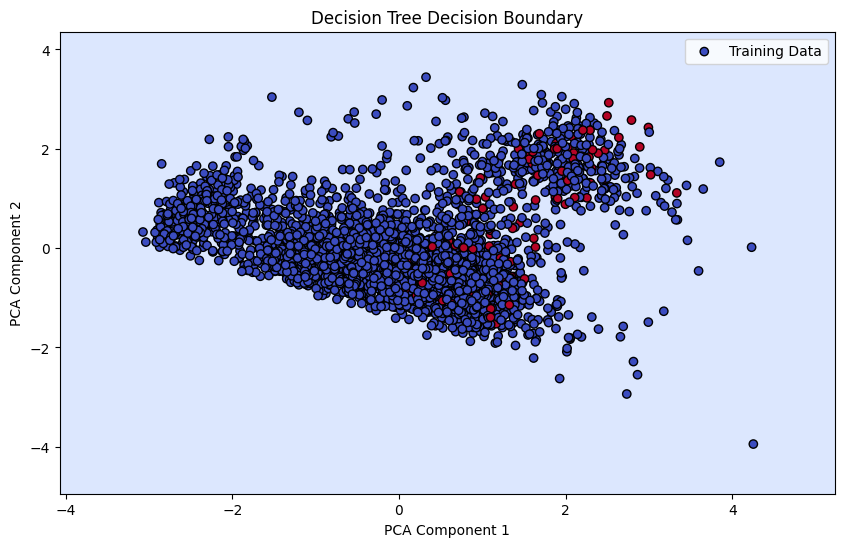

In [69]:
Z = dt.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', label="Training Data")
plt.title("Decision Tree Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [ ]:
# SVM
from sklearn.svm import SVC

svm = SVC(random_state=42, kernel='rbf', class_weight='balanced')
svm.fit(X_train_2d, y_train)
train_accuracy_svm = accuracy_score(y_train, svm.predict(X_train_2d))

print("train_accuracy_svm",train_accuracy_svm)


train_accuracy_svm 0.5703103159071848


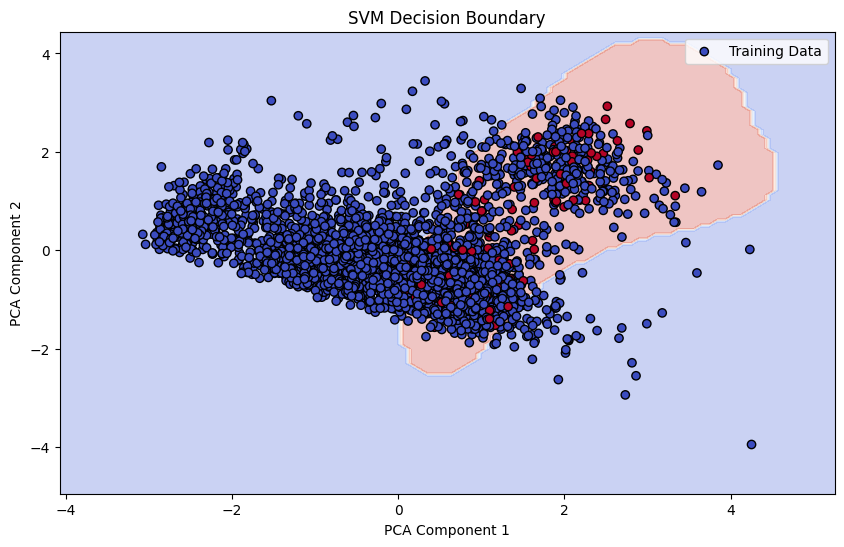

In [ ]:
# AdalineSGD 결정 경계 시각화
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', label="Training Data")
plt.title("SVM Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

plt.show()

Perceptron

Adaline - SGD
logistic regression

KNN
DecisionTree



Perceptron Test Accuracy: 0.8532


C:\Users\LYJ\AppData\Local\Temp\ipykernel_17416\171819339.py:16: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')


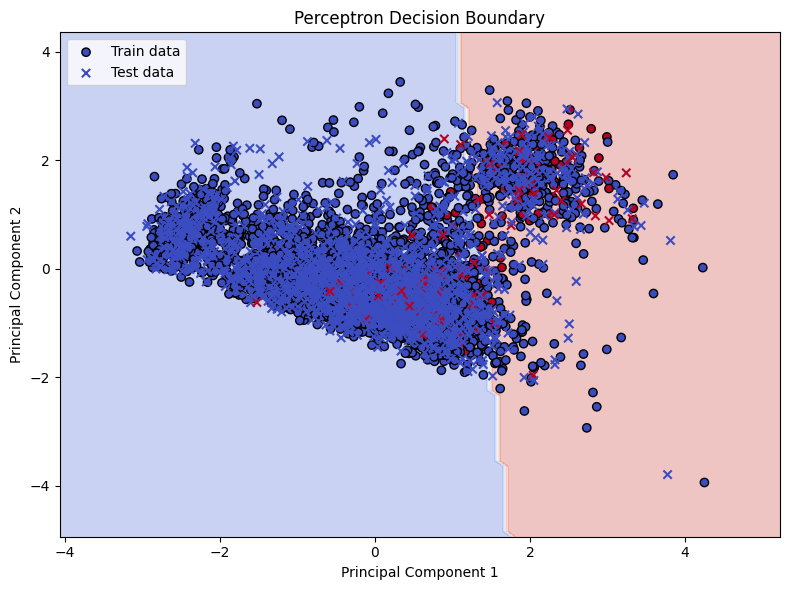

In [63]:
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
perceptron.fit(X_train_2d, y_train)
test_accuracy_perceptron = accuracy_score(y_test, perceptron.predict(X_test_2d))
print(f"Perceptron Test Accuracy: {test_accuracy_perceptron:.4f}")

xx, yy = np.meshgrid(
    np.arange(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 0.1),
    np.arange(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 0.1)
)
Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Train data')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')
plt.title('Perceptron Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Adaline - SGD Test Accuracy: 0.9511


C:\Users\LYJ\AppData\Local\Temp\ipykernel_17416\2028579902.py:14: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')


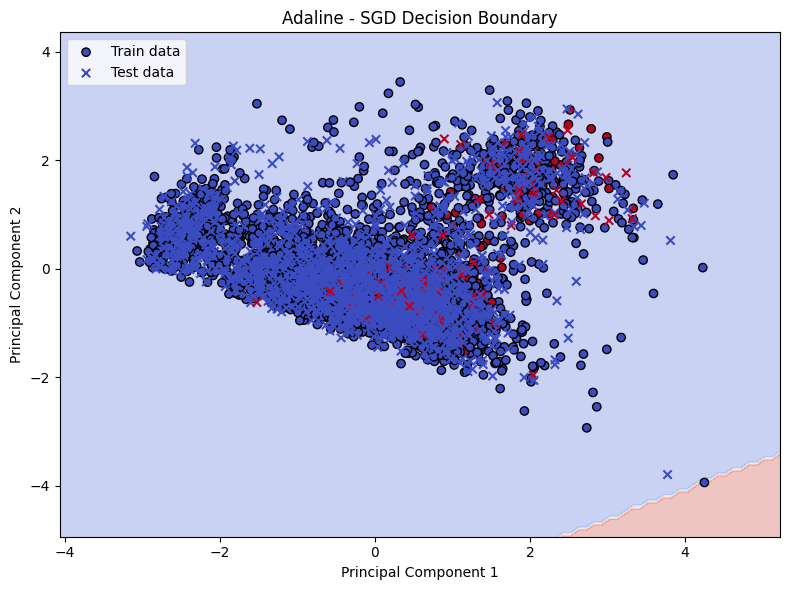

In [64]:
from sklearn.linear_model import SGDClassifier

adaline_sgd = SGDClassifier(loss='squared_error', max_iter=1000, tol=1e-3, random_state=42)
adaline_sgd.fit(X_train_2d, y_train)
test_accuracy_adaline_sgd = accuracy_score(y_test, adaline_sgd.predict(X_test_2d))
print(f"Adaline - SGD Test Accuracy: {test_accuracy_adaline_sgd:.4f}")

Z = adaline_sgd.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Train data')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')
plt.title('Adaline - SGD Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Logistic Regression Test Accuracy: 0.9511


C:\Users\LYJ\AppData\Local\Temp\ipykernel_17416\2968796393.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')


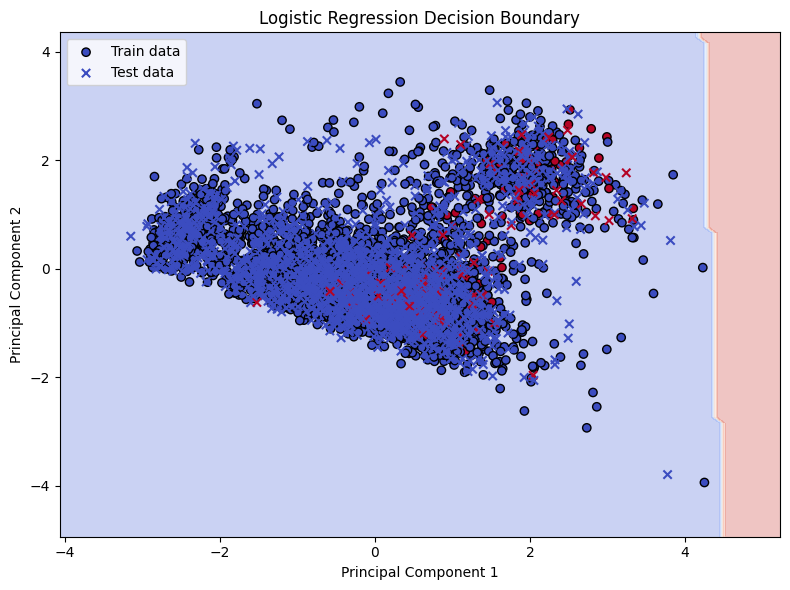

In [65]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_2d, y_train)
test_accuracy_log_reg = accuracy_score(y_test, log_reg.predict(X_test_2d))
print(f"Logistic Regression Test Accuracy: {test_accuracy_log_reg:.4f}")

Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Train data')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')
plt.title('Logistic Regression Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


KNN Test Accuracy: 0.9478


C:\Users\LYJ\AppData\Local\Temp\ipykernel_17416\3467014206.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')


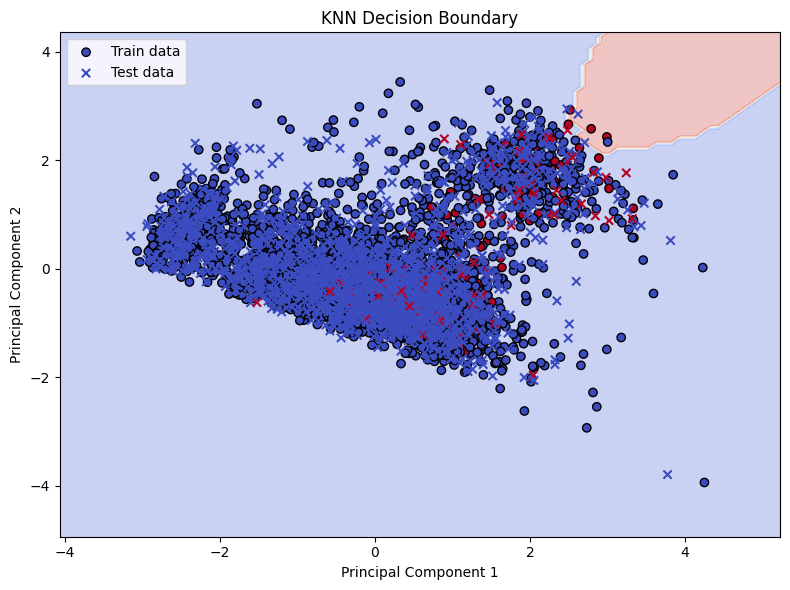

In [66]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_2d, y_train)
test_accuracy_knn = accuracy_score(y_test, knn.predict(X_test_2d))
print(f"KNN Test Accuracy: {test_accuracy_knn:.4f}")

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Train data')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')
plt.title('KNN Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Decision Tree Test Accuracy: 0.9132


C:\Users\LYJ\AppData\Local\Temp\ipykernel_17416\1408309536.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')


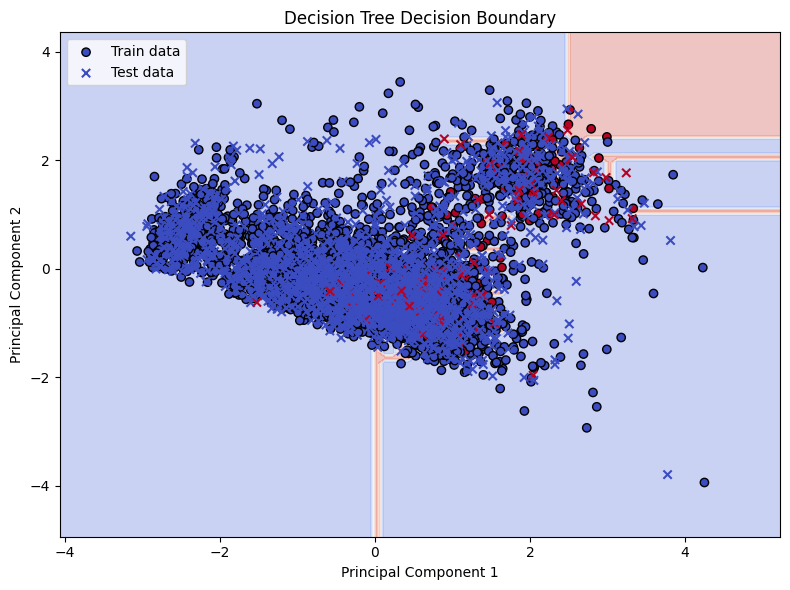

In [67]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_2d, y_train)
test_accuracy_decision_tree = accuracy_score(y_test, decision_tree.predict(X_test_2d))
print(f"Decision Tree Test Accuracy: {test_accuracy_decision_tree:.4f}")

Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Train data')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', marker='x', label='Test data')
plt.title('Decision Tree Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()